In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [3]:
df = pd.read_csv('/home/rishav/Programs/move_od/move_OD/Hamilton_Tennessee_2024-05-11_2024-05-11/lodes_combs/lodes_2024-05-11.csv')
df['departure_time'] = pd.to_datetime(df['departure_time'])
df['departure_hour'] = df['departure_time'].dt.hour
clifton  = gpd.read_file('/home/rishav/Programs/move_od/data/Clifton.json')


In [44]:
origin_geometry = [Point(xy) for xy in zip(df['origin_loc_lon'], df['origin_loc_lat'])]
origin_gdf = gpd.GeoDataFrame(df, geometry=origin_geometry)
origin_gdf.set_crs(epsg=4326, inplace=True)
clifton.set_crs(epsg=4326, inplace=True)

# Perform spatial join to limit origin locations within Clifton
origin_gdf_clifton = gpd.sjoin(origin_gdf, clifton, how='inner', op='within')
origin_gdf_clifton = origin_gdf_clifton.drop(columns=['index_right'])

# Create geometry for destination locations
dest_geometry = [Point(xy) for xy in zip(origin_gdf_clifton['dest_loc_lon'], origin_gdf_clifton['dest_loc_lat'])]
dest_gdf = gpd.GeoDataFrame(origin_gdf_clifton.drop(['geometry'], axis=1), geometry=dest_geometry)
dest_gdf.set_crs(epsg=4326, inplace=True)

# Perform spatial join to limit destination locations within Clifton
dest_gdf_clifton = gpd.sjoin(dest_gdf, clifton, how='inner', op='within')
dest_gdf_clifton = dest_gdf_clifton.drop(columns=['index_right'])

# Final GeoDataFrame with both origin and destination locations within Clifton
gdf_clifton = dest_gdf_clifton

/home/rishav/Programs/move_od/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/home/rishav/Programs/move_od/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [53]:
gdf_clifton.h_geocode.astype(str).unique()


array(['470650101032', '470650102012', '470650023001', '470650024001',
       '470650024002', '470650024003', '470650024004', '470650026002',
       '470650026003', '470650025001', '470650025004', '470650025003',
       '470650025002'], dtype=object)

In [5]:
strata_columns = ['h_geocode', 'w_geocode', 'departure_hour']
gdf_clifton['stratum'] = gdf_clifton[strata_columns].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

# Define the sampling fraction
f = 0.5  # Adjust the sampling fraction as needed

# Perform stratified sampling
def stratified_subsampling(df, stratum_col, sampling_fraction):
    strata = df[stratum_col].unique()
    subsamples = []

    for stratum in strata:
        stratum_data = df[df[stratum_col] == stratum]
        stratum_sample = stratum_data.sample(frac=sampling_fraction, random_state=42)
        subsamples.append(stratum_sample)

    sub_sample_df = pd.concat(subsamples).reset_index(drop=True)
    return sub_sample_df

# Get the sub-sample
sub_sample_df = stratified_subsampling(gdf_clifton, 'stratum', f)

# Drop the temporary stratum column if needed
sub_sample_df = sub_sample_df.drop(columns=['stratum'])

In [7]:
sub_sample_df[sub_sample_df['departure_time_secs']<(3600*6)]
# df[df['departure_time_secs']>(3600*16)]
len(sub_sample_df.h_geocode.unique())

13

In [17]:
len(sub_sample_df.w_geocode.unique())

170

In [20]:
output_path = "../move_OD/Hamilton_Tennessee_2024-05-11_2024-05-11/lodes_combs"
sub_sample_df.to_csv(f'{output_path}/2024-05-11_clifton_ODs.csv')

In [42]:
clifton.geometry.centroid

/tmp/ipykernel_81754/3741242147.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clifton.geometry.centroid


0    POINT (-85.28961 35.00519)
dtype: geometry

In [1]:
clifton

NameError: name 'clifton' is not defined

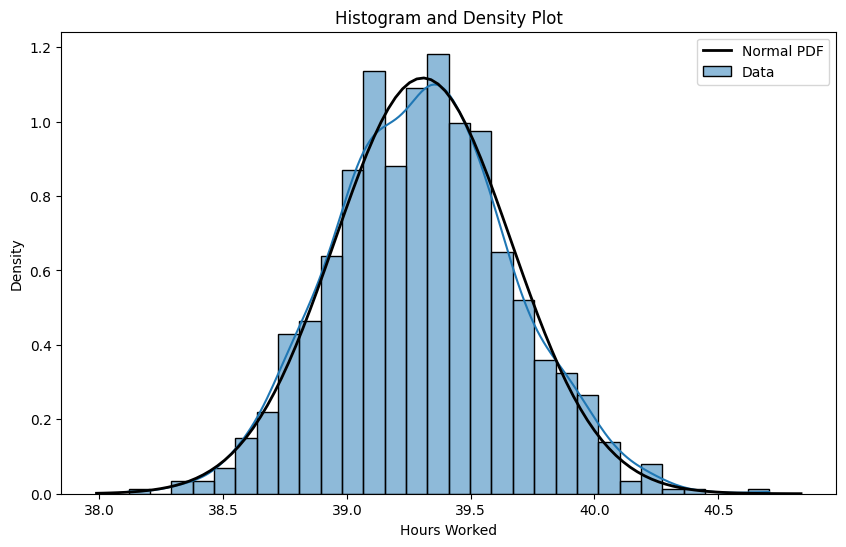

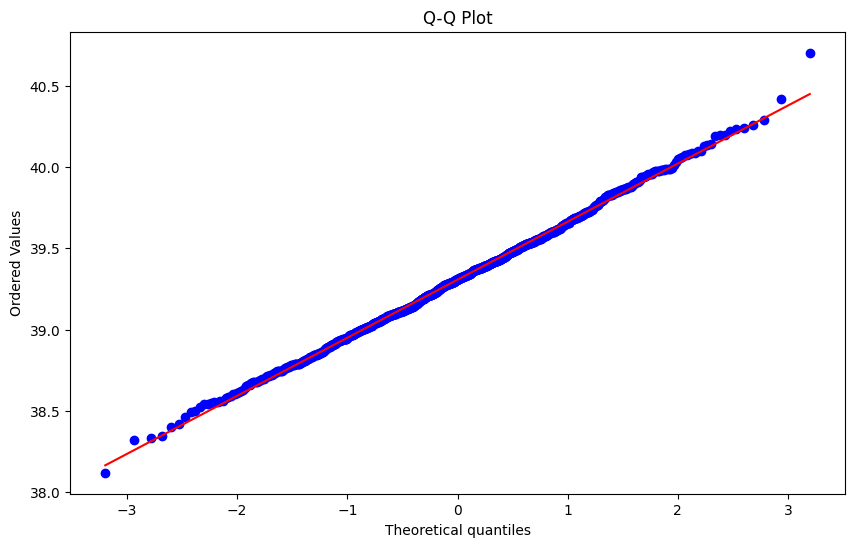

Shapiro-Wilk Test Statistic: 0.9986080527305603, p-value: 0.6264819502830505
Kolmogorov-Smirnov Test Statistic: 0.021479979161410145, p-value: 0.736956912324803
Anderson-Darling Test Statistic: 0.3474697767348971
At 15.0% significance level, critical value is 0.574
At 10.0% significance level, critical value is 0.653
At 5.0% significance level, critical value is 0.784
At 2.5% significance level, critical value is 0.914
At 1.0% significance level, critical value is 1.088


ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.00047704711506278957

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, probplot, shapiro, kstest, anderson, chisquare

mean_hours = 39.3
margin_of_error = 0.6
confidence_interval = 1.645  # 90% confidence interval

std_dev = margin_of_error / confidence_interval

np.random.seed(42)  # for reproducibility
data = np.random.normal(mean_hours, std_dev, 1000)

# Visual Inspection: Histogram and Density Plot
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, stat="density", bins=30, label="Data")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, data.mean(), data.std())
plt.plot(x, p, 'k', linewidth=2, label="Normal PDF")
plt.xlabel('Hours Worked')
plt.ylabel('Density')
plt.legend()
plt.title('Histogram and Density Plot')
plt.show()

# Visual Inspection: Q-Q Plot
plt.figure(figsize=(10, 6))
probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

# Shapiro-Wilk Test
shapiro_test = shapiro(data)
print(f"Shapiro-Wilk Test Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")

# Kolmogorov-Smirnov Test
ks_test = kstest(data, 'norm', args=(data.mean(), data.std()))
print(f"Kolmogorov-Smirnov Test Statistic: {ks_test.statistic}, p-value: {ks_test.pvalue}")

# Anderson-Darling Test
anderson_test = anderson(data, dist='norm')
print(f"Anderson-Darling Test Statistic: {anderson_test.statistic}")
for i in range(len(anderson_test.critical_values)):
    sig_level, crit_value = anderson_test.significance_level[i], anderson_test.critical_values[i]
    print(f"At {sig_level}% significance level, critical value is {crit_value}")

# Goodness-of-Fit Measures: Chi-Square Goodness-of-Fit Test
observed_freq, bins = np.histogram(data, bins='auto')
expected_freq = len(data) * (norm.cdf(bins[1:], data.mean(), data.std()) - norm.cdf(bins[:-1], data.mean(), data.std()))
chi2_stat, p_val = chisquare(observed_freq, expected_freq)
print(f"Chi-Square Test Statistic: {chi2_stat}, p-value: {p_val}")


In [64]:
lodes = pd.read_csv('/home/rishav/Programs/move_od/move_OD/Hamilton_Tennessee_2024-05-29_2024-05-29/county_lodes.csv')
cbg = gpd.read_file('/home/rishav/Programs/move_od/data/states/Tennessee/tl_2023_47_bg.zip')

In [74]:
cbg.to_crs('epsg:4326')
gpd.sjoin(cbg, clifton, how='inner')

/tmp/ipykernel_20797/401813838.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: EPSG:4326

  gpd.sjoin(cbg, clifton, how='inner')


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,index_right,id
497,47,065,001900,3,470650019003,1500000US470650019003,Block Group 3,G5030,S,3775609,30874,+34.9921690,-085.3124516,"POLYGON ((-85.32845 35.01039, -85.32844 35.010...",0,CARTAlink
560,47,065,002000,1,470650020001,1500000US470650020001,Block Group 1,G5030,S,1811273,0,+35.0323988,-085.3085296,"POLYGON ((-85.31969 35.03708, -85.31966 35.037...",0,CARTAlink
694,47,065,002500,2,470650025002,1500000US470650025002,Block Group 2,G5030,S,1331116,0,+35.0124213,-085.2883808,"POLYGON ((-85.29445 35.01304, -85.29443 35.013...",0,CARTAlink
1098,47,065,002500,1,470650025001,1500000US470650025001,Block Group 1,G5030,S,1523238,5111,+35.0050021,-085.2715189,"POLYGON ((-85.27956 34.99976, -85.27930 35.000...",0,CARTAlink
1346,47,065,003100,1,470650031001,1500000US470650031001,Block Group 1,G5030,S,716079,0,+35.0417014,-085.3106386,"POLYGON ((-85.31748 35.03992, -85.31727 35.040...",0,CARTAlink
1348,47,065,002400,1,470650024001,1500000US470650024001,Block Group 1,G5030,S,1107678,0,+34.9907351,-085.2770942,"POLYGON ((-85.28390 34.98974, -85.28364 34.990...",0,CARTAlink
2583,47,065,012400,3,470650124003,1500000US470650124003,Block Group 3,G5030,S,1169400,0,+35.0382648,-085.3003883,"POLYGON ((-85.30756 35.03952, -85.30741 35.039...",0,CARTAlink
2586,47,065,001900,1,470650019001,1500000US470650019001,Block Group 1,G5030,S,2306200,0,+35.0060577,-085.3096324,"POLYGON ((-85.32003 35.00071, -85.31994 35.000...",0,CARTAlink
2594,47,065,002300,1,470650023001,1500000US470650023001,Block Group 1,G5030,S,4343924,95202,+35.0022212,-085.2987814,"POLYGON ((-85.30624 35.00137, -85.30623 35.001...",0,CARTAlink
2709,47,065,002000,2,470650020002,1500000US470650020002,Block Group 2,G5030,S,1713942,0,+35.0252241,-085.3160603,"POLYGON ((-85.33313 35.01867, -85.33304 35.018...",0,CARTAlink
